<a href="https://colab.research.google.com/github/Asigen93/finetuningGAN/blob/main/tes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install versi PyTorch yang stabil untuk CUDA Colab**

In [5]:
!pip install torch==2.8.0 torchvision==0.23.0 torchaudio==2.8.0 --index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://download.pytorch.org/whl/cu126


# **Install library pendukung untuk GAN dan visualisasi**

In [6]:
!pip install numpy matplotlib tqdm pillow seaborn
!pip install einops --quiet

# **Import dan cek versi PyTorch**

In [7]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

PyTorch version: 2.8.0+cu126
CUDA available: False
GPU: No GPU


# **Siapkan Dataset**

In [8]:
# === Hubungkan Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

# === Import library utama ===
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# === Lokasi dataset di Drive ===
base_dir = '/content/drive/MyDrive/ayam'

# === Transformasi gambar ===
transform = transforms.Compose([
    transforms.Resize((64, 64)),           # ubah ukuran semua gambar ke 64x64
    transforms.ToTensor(),                 # ubah ke tensor PyTorch
    transforms.Normalize([0.5], [0.5])     # normalisasi agar data seimbang (-1, 1)
])

# === Load dataset ===
dataset = datasets.ImageFolder(root=base_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# === Cek total gambar ===
print("✅ Jumlah gambar berhasil dimuat:", len(dataset))

Mounted at /content/drive
✅ Jumlah gambar berhasil dimuat: 1358


# **Definisikan Arsitektur GAN (Generator + Discriminator)**

In [9]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, features_g=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, features_g*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features_g*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g*8, features_g*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g*4, features_g*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g*2, features_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, img_channels=3, features_d=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, features_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features_d, features_d*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features_d*2, features_d*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features_d*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# **Latih Model GAN**

In [11]:
import torch.optim as optim
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
z_dim = 100
lr = 0.0002
epochs = 50

gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, z_dim, 1, 1).to(device)

for epoch in range(epochs):
    for real, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        real = real.to(device)
        batch_size = real.size(0)
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator
        disc_real = disc(real).reshape(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        opt_disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        ### Train Generator
        output = disc(fake).reshape(-1)
        lossG = criterion(output, torch.ones_like(output))
        opt_gen.zero_grad()
        lossG.backward()
        opt_gen.step()

    print(f"Epoch [{epoch+1}/{epochs}] | Loss D: {lossD:.4f} | Loss G: {lossG:.4f}")

Epoch 1/50: 100%|██████████| 22/22 [12:47<00:00, 34.90s/it]


Epoch [1/50] | Loss D: 0.6795 | Loss G: 1.5260


Epoch 2/50: 100%|██████████| 22/22 [05:10<00:00, 14.09s/it]


Epoch [2/50] | Loss D: 0.6793 | Loss G: 1.6369


Epoch 3/50: 100%|██████████| 22/22 [05:09<00:00, 14.05s/it]


Epoch [3/50] | Loss D: 0.5928 | Loss G: 1.6346


Epoch 4/50: 100%|██████████| 22/22 [05:09<00:00, 14.05s/it]


Epoch [4/50] | Loss D: 0.6058 | Loss G: 1.3689


Epoch 5/50: 100%|██████████| 22/22 [05:01<00:00, 13.72s/it]


Epoch [5/50] | Loss D: 0.5351 | Loss G: 1.5908


Epoch 6/50: 100%|██████████| 22/22 [04:58<00:00, 13.55s/it]


Epoch [6/50] | Loss D: 0.4659 | Loss G: 1.6916


Epoch 7/50: 100%|██████████| 22/22 [05:12<00:00, 14.22s/it]


Epoch [7/50] | Loss D: 0.4236 | Loss G: 1.8165


Epoch 8/50: 100%|██████████| 22/22 [04:59<00:00, 13.64s/it]


Epoch [8/50] | Loss D: 0.3789 | Loss G: 2.3338


Epoch 9/50: 100%|██████████| 22/22 [05:15<00:00, 14.33s/it]


Epoch [9/50] | Loss D: 0.3924 | Loss G: 2.9122


Epoch 10/50: 100%|██████████| 22/22 [05:03<00:00, 13.81s/it]


Epoch [10/50] | Loss D: 0.3012 | Loss G: 3.0583


Epoch 11/50: 100%|██████████| 22/22 [05:08<00:00, 14.02s/it]


Epoch [11/50] | Loss D: 0.1875 | Loss G: 3.2791


Epoch 12/50: 100%|██████████| 22/22 [05:04<00:00, 13.85s/it]


Epoch [12/50] | Loss D: 0.1846 | Loss G: 3.4335


Epoch 13/50: 100%|██████████| 22/22 [05:11<00:00, 14.14s/it]


Epoch [13/50] | Loss D: 0.2061 | Loss G: 3.0615


Epoch 14/50: 100%|██████████| 22/22 [05:09<00:00, 14.09s/it]


Epoch [14/50] | Loss D: 0.1359 | Loss G: 3.6883


Epoch 15/50: 100%|██████████| 22/22 [05:03<00:00, 13.81s/it]


Epoch [15/50] | Loss D: 0.1773 | Loss G: 2.9867


Epoch 16/50: 100%|██████████| 22/22 [05:10<00:00, 14.10s/it]


Epoch [16/50] | Loss D: 0.2016 | Loss G: 3.3987


Epoch 17/50: 100%|██████████| 22/22 [05:11<00:00, 14.16s/it]


Epoch [17/50] | Loss D: 0.1871 | Loss G: 3.5065


Epoch 18/50: 100%|██████████| 22/22 [05:10<00:00, 14.10s/it]


Epoch [18/50] | Loss D: 0.1254 | Loss G: 4.0881


Epoch 19/50: 100%|██████████| 22/22 [05:13<00:00, 14.26s/it]


Epoch [19/50] | Loss D: 0.1149 | Loss G: 4.2298


Epoch 20/50: 100%|██████████| 22/22 [05:05<00:00, 13.87s/it]


Epoch [20/50] | Loss D: 0.1964 | Loss G: 4.1506


Epoch 21/50: 100%|██████████| 22/22 [05:11<00:00, 14.16s/it]


Epoch [21/50] | Loss D: 0.1680 | Loss G: 3.9443


Epoch 22/50: 100%|██████████| 22/22 [05:08<00:00, 14.02s/it]


Epoch [22/50] | Loss D: 0.1144 | Loss G: 4.1876


Epoch 23/50: 100%|██████████| 22/22 [05:10<00:00, 14.12s/it]


Epoch [23/50] | Loss D: 0.1278 | Loss G: 3.8824


Epoch 24/50: 100%|██████████| 22/22 [05:09<00:00, 14.05s/it]


Epoch [24/50] | Loss D: 0.0887 | Loss G: 5.1829


Epoch 25/50: 100%|██████████| 22/22 [05:08<00:00, 14.01s/it]


Epoch [25/50] | Loss D: 0.2183 | Loss G: 2.8059


Epoch 26/50: 100%|██████████| 22/22 [05:06<00:00, 13.93s/it]


Epoch [26/50] | Loss D: 0.2415 | Loss G: 5.6131


Epoch 27/50: 100%|██████████| 22/22 [05:05<00:00, 13.87s/it]


Epoch [27/50] | Loss D: 0.0842 | Loss G: 4.4350


Epoch 28/50: 100%|██████████| 22/22 [05:09<00:00, 14.07s/it]


Epoch [28/50] | Loss D: 0.1046 | Loss G: 4.1146


Epoch 29/50: 100%|██████████| 22/22 [05:13<00:00, 14.27s/it]


Epoch [29/50] | Loss D: 0.1301 | Loss G: 4.5801


Epoch 30/50: 100%|██████████| 22/22 [05:04<00:00, 13.85s/it]


Epoch [30/50] | Loss D: 0.0776 | Loss G: 5.3512


Epoch 31/50: 100%|██████████| 22/22 [05:10<00:00, 14.12s/it]


Epoch [31/50] | Loss D: 0.1106 | Loss G: 5.7220


Epoch 32/50: 100%|██████████| 22/22 [05:07<00:00, 13.97s/it]


Epoch [32/50] | Loss D: 0.0557 | Loss G: 5.1046


Epoch 33/50: 100%|██████████| 22/22 [05:05<00:00, 13.90s/it]


Epoch [33/50] | Loss D: 0.1575 | Loss G: 6.1889


Epoch 34/50: 100%|██████████| 22/22 [04:59<00:00, 13.61s/it]


Epoch [34/50] | Loss D: 0.1652 | Loss G: 5.8793


Epoch 35/50: 100%|██████████| 22/22 [05:09<00:00, 14.07s/it]


Epoch [35/50] | Loss D: 0.1261 | Loss G: 5.4698


Epoch 36/50: 100%|██████████| 22/22 [05:12<00:00, 14.20s/it]


Epoch [36/50] | Loss D: 0.0629 | Loss G: 4.6904


Epoch 37/50: 100%|██████████| 22/22 [05:06<00:00, 13.93s/it]


Epoch [37/50] | Loss D: 0.0589 | Loss G: 4.7282


Epoch 38/50: 100%|██████████| 22/22 [05:10<00:00, 14.10s/it]


Epoch [38/50] | Loss D: 0.1108 | Loss G: 7.7827


Epoch 39/50: 100%|██████████| 22/22 [05:14<00:00, 14.30s/it]


Epoch [39/50] | Loss D: 0.1045 | Loss G: 5.7910


Epoch 40/50: 100%|██████████| 22/22 [05:11<00:00, 14.15s/it]


Epoch [40/50] | Loss D: 0.1385 | Loss G: 4.9615


Epoch 41/50: 100%|██████████| 22/22 [05:14<00:00, 14.29s/it]


Epoch [41/50] | Loss D: 0.0786 | Loss G: 6.2901


Epoch 42/50: 100%|██████████| 22/22 [05:08<00:00, 14.00s/it]


Epoch [42/50] | Loss D: 0.0916 | Loss G: 5.1383


Epoch 43/50: 100%|██████████| 22/22 [05:09<00:00, 14.06s/it]


Epoch [43/50] | Loss D: 0.0478 | Loss G: 5.0843


Epoch 44/50: 100%|██████████| 22/22 [05:07<00:00, 13.96s/it]


Epoch [44/50] | Loss D: 0.0824 | Loss G: 4.9339


Epoch 45/50: 100%|██████████| 22/22 [05:06<00:00, 13.93s/it]


Epoch [45/50] | Loss D: 0.1133 | Loss G: 5.3168


Epoch 46/50: 100%|██████████| 22/22 [05:13<00:00, 14.25s/it]


Epoch [46/50] | Loss D: 0.1176 | Loss G: 6.5547


Epoch 47/50: 100%|██████████| 22/22 [05:10<00:00, 14.11s/it]


Epoch [47/50] | Loss D: 0.0504 | Loss G: 5.1319


Epoch 48/50: 100%|██████████| 22/22 [05:08<00:00, 14.02s/it]


Epoch [48/50] | Loss D: 0.0773 | Loss G: 4.7766


Epoch 49/50: 100%|██████████| 22/22 [05:05<00:00, 13.89s/it]


Epoch [49/50] | Loss D: 0.1229 | Loss G: 4.0293


Epoch 50/50: 100%|██████████| 22/22 [05:07<00:00, 13.98s/it]

Epoch [50/50] | Loss D: 0.0425 | Loss G: 4.5242


# **Visualisasi Hasil Gambar**

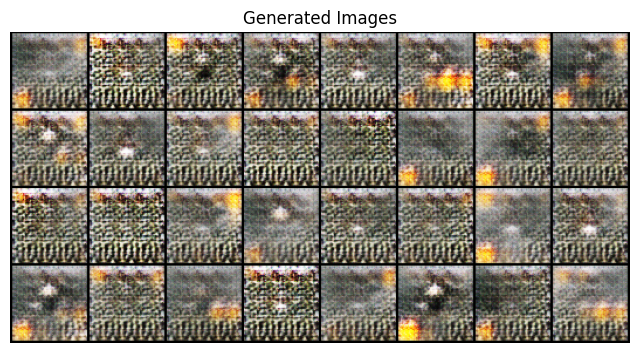

In [12]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

with torch.no_grad():
    fake_images = gen(fixed_noise).detach().cpu()

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(
    vutils.make_grid(fake_images, padding=2, normalize=True).permute(1, 2, 0)
)
plt.show()

# **Simpan Model (opsional)**

In [14]:
torch.save(gen.state_dict(), "generator.pth")
torch.save(disc.state_dict(), "discriminator.pth")